# Import Necessary Libraries

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models

# Data Loading and Preprocessing

In [26]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
val_size = int(len(train_data) * 0.2)
train_size = len(train_data) - val_size

train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model Training and Evaluation Functions

In [5]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    best_val_acc = 0
    losses = []
    accuracies = []
    losses_val = []
    accuracies_val = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        losses.append(train_loss)
        accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        losses_val.append(val_loss)
        accuracies_val.append(val_acc)
        epoch_times.append(time.time() - start_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model, losses, accuracies, losses_val, accuracies_val, epoch_times

In [29]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    loss /= len(data_loader)
    accuracy = 100. * correct / total
    return accuracy



In [30]:
def plot_training_results(losses, accuracies, epochs=50):
    """
    Plots training loss and accuracy over epochs.

    Parameters:
        losses (list): A list of loss values per epoch.
        accuracies (list): A list of accuracy values per epoch.
        epochs (int): Total number of epochs (default is 50).
    """
    plt.figure(figsize=(10, 5))  # Adjusted figure size for smaller plots

    # Plot Loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    plt.plot(range(1, epochs + 1), losses, marker='o', label='Loss', color='blue')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    plt.plot(range(1, epochs + 1), accuracies, marker='o', label='Accuracy', color='green')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, epochs + 1, max(epochs // 10, 1)))  # Adjust x-ticks based on epochs
    plt.legend()

    # Show plots
    plt.tight_layout()  # Automatically adjust layout to prevent overlap
    plt.show()


# Visualizing a Sample Image and Labels

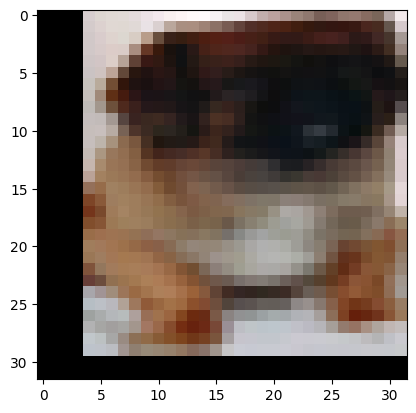

Eticheta imaginii: 5


In [35]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(images[3])
print('Eticheta imaginii:', labels[3].item())

In [36]:
import pandas as pd

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

df = pd.DataFrame({'Class Name': classes})

print(df)

   Class Name
0    airplane
1  automobile
2        bird
3         cat
4        deer
5         dog
6        frog
7       horse
8        ship
9       truck


# Pretrained MobileNet results

In [37]:
model_MN = models.mobilenet_v2(pretrained=True)

model_MN.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model_MN.classifier[1].in_features, 10)
)
model_MN = model_MN.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MN.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
trained_model_MN, train_losses_MN, train_accuracies_MN, val_losses_MN, val_accuracies_MN, epoch_times_MN = train_model(model_MN, train_loader,val_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25], Train Loss: 1.4030, Train Acc: 49.34%, Val Loss: 1.0699, Val Acc: 62.50%
Epoch [2/25], Train Loss: 1.0594, Train Acc: 62.28%, Val Loss: 0.9117, Val Acc: 67.70%
Epoch [3/25], Train Loss: 0.9271, Train Acc: 67.39%, Val Loss: 0.8382, Val Acc: 70.80%
Epoch [4/25], Train Loss: 0.8467, Train Acc: 69.95%, Val Loss: 0.7789, Val Acc: 72.90%
Epoch [5/25], Train Loss: 0.7931, Train Acc: 72.14%, Val Loss: 0.7485, Val Acc: 73.89%
Epoch [6/25], Train Loss: 0.7569, Train Acc: 73.42%, Val Loss: 0.7304, Val Acc: 73.82%
Epoch [7/25], Train Loss: 0.7163, Train Acc: 74.62%, Val Loss: 0.6831, Val Acc: 75.45%
Epoch [8/25], Train Loss: 0.6858, Train Acc: 75.84%, Val Loss: 0.6615, Val Acc: 76.65%
Epoch [9/25], Train Loss: 0.6540, Train Acc: 77.08%, Val Loss: 0.6333, Val Acc: 78.24%
Epoch [10/25], Train Loss: 0.6319, Train Acc: 77.74%, Val Loss: 0.6435, Val Acc: 77.68%
Epoch [11/25], Train Loss: 0.6126, Train Acc: 78.54%, Val Loss: 0.6170, Val Acc: 78.57%
Epoch [12/25], Train Loss: 0.5888, Train 

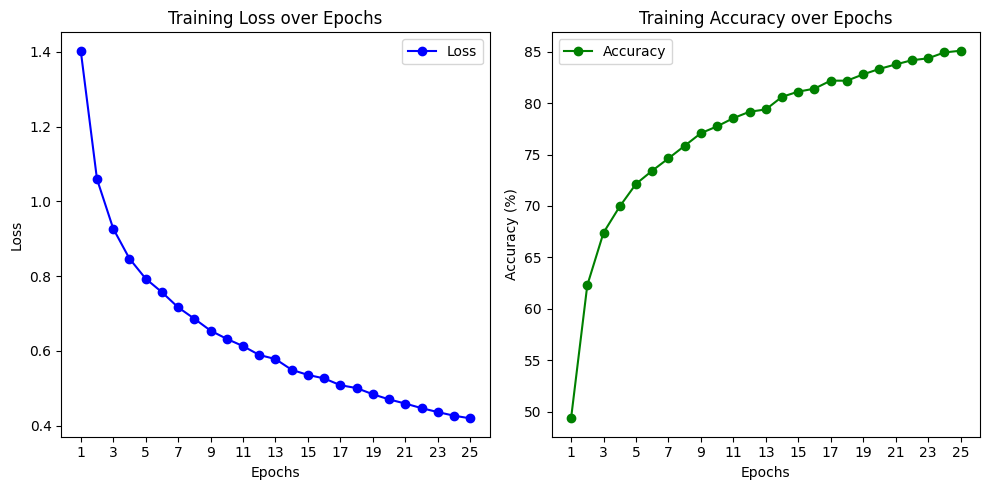

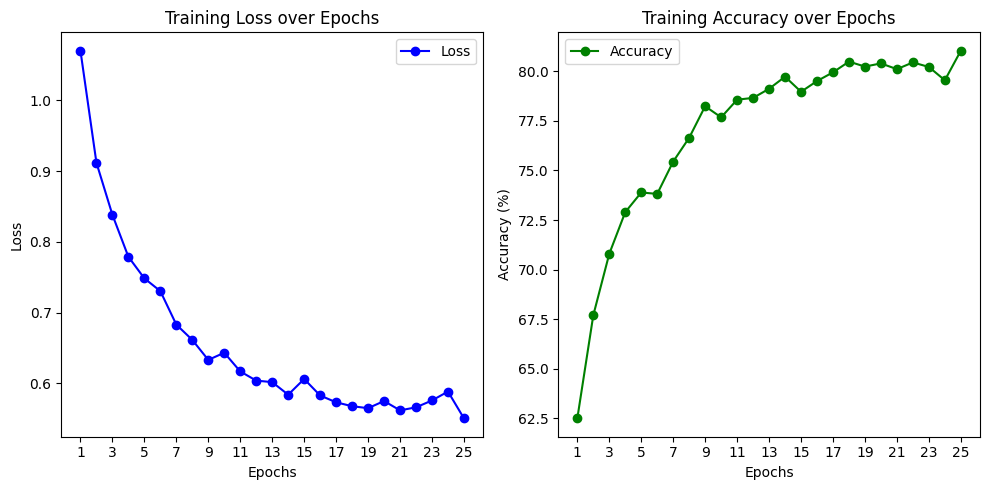

In [39]:
plot_training_results(train_losses_MN, train_accuracies_MN, epochs=25)
plot_training_results(val_losses_MN, val_accuracies_MN, epochs=25)

In [40]:
evaluate_model(trained_model_MN, test_loader, criterion)

80.27

# Exporting the model to ONNX

In [43]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 94.9 MB/s eta 0:00:00


In [44]:
dummy_input = torch.randn(1, 3, 32, 32)
dummy_input = dummy_input.to(device)
torch.onnx.export(trained_model_MN, dummy_input, "cifar10_mobileNet.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})
print("Modelul a fost salvat ca cifar10_mobileNet.onnx")


Modelul a fost salvat ca cifar10_mobileNet.onnx


# MobileNet with no Pretraining

In [46]:
model_MN_pf = models.mobilenet_v2(pretrained=False)

model_MN_pf.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model_MN_pf.classifier[1].in_features, 10)
)
model_MN_pf = model_MN_pf.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_MN_pf.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [47]:
trained_model_MN_pf, train_losses_MN_pf, train_accuracies_MN_pf, val_losses_MN_pf, val_accuracies_MN_pf, epoch_times_MN_pf = train_model(model_MN_pf, train_loader,val_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25], Train Loss: 2.3006, Train Acc: 13.31%, Val Loss: 2.2463, Val Acc: 16.12%
Epoch [2/25], Train Loss: 2.2239, Train Acc: 16.79%, Val Loss: 2.1463, Val Acc: 19.15%
Epoch [3/25], Train Loss: 2.1358, Train Acc: 20.15%, Val Loss: 2.0828, Val Acc: 22.66%
Epoch [4/25], Train Loss: 2.0716, Train Acc: 22.40%, Val Loss: 2.0212, Val Acc: 24.81%
Epoch [5/25], Train Loss: 2.0164, Train Acc: 24.60%, Val Loss: 1.9615, Val Acc: 27.17%
Epoch [6/25], Train Loss: 1.9572, Train Acc: 26.91%, Val Loss: 1.8913, Val Acc: 29.08%
Epoch [7/25], Train Loss: 1.8888, Train Acc: 29.38%, Val Loss: 1.8152, Val Acc: 31.69%
Epoch [8/25], Train Loss: 1.8273, Train Acc: 31.54%, Val Loss: 1.7628, Val Acc: 34.23%
Epoch [9/25], Train Loss: 1.7699, Train Acc: 33.69%, Val Loss: 1.7081, Val Acc: 35.48%
Epoch [10/25], Train Loss: 1.7305, Train Acc: 34.88%, Val Loss: 1.6638, Val Acc: 37.66%
Epoch [11/25], Train Loss: 1.6879, Train Acc: 37.15%, Val Loss: 1.6121, Val Acc: 39.72%
Epoch [12/25], Train Loss: 1.6476, Train 

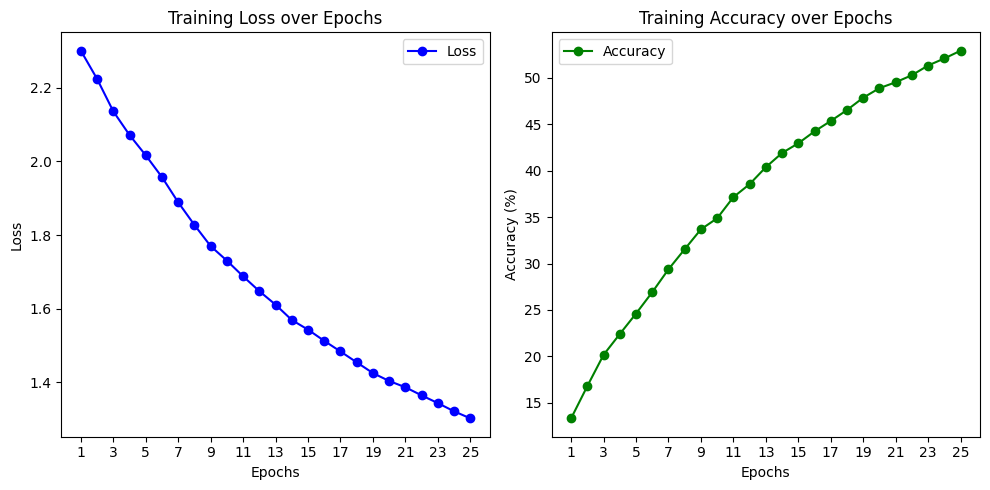

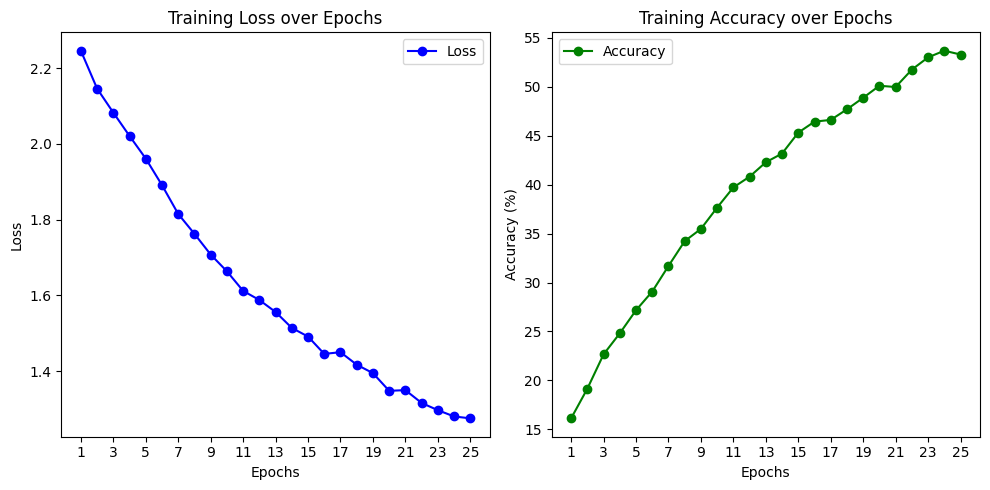

In [48]:
plot_training_results(train_losses_MN_pf, train_accuracies_MN_pf, epochs=25)
plot_training_results(val_losses_MN_pf, val_accuracies_MN_pf, epochs=25)

In [49]:
evaluate_model(trained_model_MN_pf, test_loader, criterion)

53.84

In [52]:
dummy_input = torch.randn(1, 3, 32, 32)
dummy_input = dummy_input.to(device)
torch.onnx.export(trained_model_MN_pf, dummy_input, "cifar10_mobileNetPreatrainedFalse.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}})
print("Modelul a fost salvat ca cifar10_mobileNetPreatrainedFalse.onnx")


Modelul a fost salvat ca cifar10_mobileNetPreatrainedFalse.onnx
